# Part 1 - Localization from one camera

### Importing libraries

In [1]:
from helpers.setup import parse_config_file
import sys
import numpy as np
import time

from sklearn.decomposition import PCA
from scipy import io
from scipy.spatial.distance import cdist

import cv2 
from cv2 import DMatch

### Getting features from video

This function implements the SIFT algorithm to find keypoints of the image

In [2]:
def get_features(vid_capture, frames_to_process):
    features = np.zeros((1, frames_to_process), dtype=object)
    frames = []
    keypoints_array = []
    current_frame = 0 
    while(vid_capture.isOpened()):
        # vid_capture.read() methods returns a tuple, first element is a bool 
        # and the second is frame
        for _ in range(100):
            ret, frame = vid_capture.read()
            
        sift = cv2.SIFT_create()
        if ret == True:
            # getting keypoints and descriptor
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
            keypoints, descriptor = sift.detectAndCompute(frame_gray, None)
            keypoints_array.append(keypoints)

            # getting the location of each keypoint
            x_location = []
            y_location = []
            for keypoint in keypoints:
                x_location.append(keypoint.pt[0])
                y_location.append(keypoint.pt[1])
            ## (x, y, d)
            concatenation = np.insert(np.transpose(descriptor), [0, 1], [x_location, y_location], axis=0)
            #print(f'concatenation: {np.shape(concatenation)}') 
            features[0, current_frame] = concatenation

            current_frame += 1
            frames.append(frame)
            static_frame = cv2.drawKeypoints(frame, keypoints, None, color=(0, 255, 0))
            cv2.imwrite(f"./debugfiles/keypoints/{config['videos'].split('.mp4')[0].split('/')[1]}_keypoints_frame_{current_frame}.png", static_frame)
            cv2.imshow('Static Keypoints', static_frame)
            
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

            if current_frame == frames_to_process:
                break
        else:
            break
    # print(features.shape)
    vid_capture.release()
    cv2.destroyAllWindows()
    return features, frames, keypoints_array

### Finding matches from keypoint descriptors from two images

In [48]:
def match_features(features1, features2, matches_size = 100, num_features= 64):
    C = np.vstack((features1, features2))
    
    # PCA
    pca = PCA(n_components=num_features)
    reconstructed = pca.fit_transform(C)
    
    features1 = reconstructed[:len(features1), :]
    features2 = reconstructed[len(features1):, :]
    
    # Euclidean distance
    D = cdist(features1, features2, 'euclidean')
    
    # Sorting distances and finding nearest neighbors
    I = np.argsort(D, axis=1)
    nearest_neighbor = D[np.arange(len(D)), I[:, 0]]
    second_nearest_neighbor = D[np.arange(len(D)), I[:, 1]]
    confidences = nearest_neighbor / second_nearest_neighbor
    
    # Filtering non-zero confidences
    i = np.where(confidences)[0]
    matches = np.column_stack((i, I[i]))
    confidences = 1.0 / confidences[i]
    
    # Sorting by confidence and selecting top 100 matches
    sorted_indices = np.argsort(confidences)[::-1]
    matches = matches[sorted_indices][:matches_size, :]
    confidences = confidences[sorted_indices][:matches_size]

    matches = [DMatch(_queryIdx=int(match[0]), 
                      _trainIdx=int(match[1]), 
                      _distance=float(D[int(match[0]), int(match[1])])) 
                          for match in matches]
    
    return matches, confidences

### Creating homography matrix  from sets of points

From two sets of points this function compute the homography between them

In [73]:
def create_homography_matrix(src_points, dst_points):
    A = []
    b = [] 
    for i in range(len(src_points)):
        x, y = src_points[i]
        u, v = dst_points[i]
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y])

        b.append(u)
        b.append(v)
    try:
        A = np.array(A)
        h = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)), b)
        h = np.append(h, 1) 
        h = h.reshape(3,3)
    except Exception as e:
        rollbar.report_exc_info()
        exit()
    
    return h

### Homography from features

In [46]:
def homographies_from_features(features, frames_to_process):
    homographies = []
    for i in range(frames_to_process):
        for j in range(i+1, frames_to_process):
            matches, confidences = match_features(np.transpose(features[0, i][2:]), np.transpose(features[0, j][2:]), matches_size=100)

            src_points = []
            dst_points = []

            for match in matches:
                src_points.append(features[0, i][0:2, match.queryIdx])
                dst_points.append(features[0, j][0:2, match.trainIdx])
                
            homography = [i+1, j+1]
            homography_matrix = create_homography_matrix(src_points, dst_points)
            homography.extend(homography_matrix.flatten())
            homographies.append(homography)
            
            matched_img = cv2.drawMatches(frames[i], keypoints_array[i], frames[j], keypoints_array[j], matches, None, flags=2)
            h, w, _ = matched_img.shape
            matched_img = cv2.resize(matched_img, (int(3*w/4), int(3*h/4)), interpolation = cv2.INTER_LINEAR)
            cv2.putText(matched_img, f"{i}, {j}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.imwrite(f"./debugfiles/matches/{config['videos'].split('.mp4')[0].split('/')[1]}_matches_frame_{i+1}_{j+1}.png", matched_img)
            cv2.imshow('Matches', matched_img)

            img_i = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
            img_j = cv2.cvtColor(frames[j], cv2.COLOR_BGR2GRAY)

            # Warp img_i to img_j using the computed homography
            img_i_warped = cv2.warpPerspective(img_i, homography_matrix, (img_j.shape[1], img_j.shape[0]))

            # Concatenate the two images side by side for visualization
            concatenated_imgs = np.concatenate((img_j, img_i_warped), axis=1)
            h, w = concatenated_imgs.shape
            concatenated_imgs = cv2.resize(concatenated_imgs, (int(1*w/2), int(1*h/2)), interpolation = cv2.INTER_LINEAR)
            cv2.imwrite(f"./debugfiles/homography/{config['videos'].split('.mp4')[0].split('/')[1]}_homography_frame_{i+1}_{j+1}.png", concatenated_imgs)
            cv2.imshow(f"Homography", concatenated_imgs)
            
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
    cv2.destroyAllWindows()
    return homographies

### Homography from corresponding points (map)

In [6]:
def homographies_from_corresponding_points(pts_in_map_from_config, pts_in_frame_from_config):
    homographies = []
    for i in range(len(pts_in_map_from_config)):
        pts_in_map = np.array(pts_in_map_from_config[i][1:], dtype=float)
        pts_in_map = pts_in_map.reshape(int(len(pts_in_map)/2), 2)
        pts_in_frame = np.array(pts_in_frame_from_config[i][1:], dtype=float)
        pts_in_frame = pts_in_frame.reshape(int(len(pts_in_frame)/2), 2)
        homography = [0, int(pts_in_frame_from_config[i][0])]
        homography.extend(create_homography_matrix(pts_in_map, pts_in_frame).flatten())
        homographies.append(homography)
    return homographies

### `processing_video.py` main

In [7]:
config_path = "./conf_file.cpg"
config = parse_config_file(config_path)

vid_capture = cv2.VideoCapture(config['videos'])
frames_to_process = 5

features, frames, keypoints_array = get_features(vid_capture, frames_to_process)
data={'features': features}
io.savemat(config['keypoints_out'], data)

### `compute_transform.py` main

In [49]:
config_path = "./conf_file.cpg"
config = parse_config_file(config_path)

if config['transforms'][0][0] == 'homography':
    if config['transforms'][0][1] == 'all':
        homographies = homographies_from_features(features, frames_to_process)
    elif config['transforms'][0][1] == 'map':
        if len(config['pts_in_map']) != len(config['pts_in_frame']):
            print("Different amount of pts_in_map and pts_in_frame defined inside the config file")
            sys.exit(1)
        homographies = homographies_from_corresponding_points(config['pts_in_map'], config['pts_in_frame'])
    data={'transforms': np.array(homographies).transpose()}
    io.savemat(config['transforms_out'], data)
else:
    print("The only acceptable type is \"homography\"")

### Implementing RANSAC to remove outliers
WORKING...

In [78]:
def ransac_homography_custom(src_points, dst_points, i, j, iterations=100, threshold=5.0):
    src_points = np.array(src_points)
    dst_points = np.array(dst_points)
    best_homography = None
    max_inliers = 0
    n_points = src_points.shape[0]
    best_projects = None

    for _ in range(iterations):
        # Randomly select 4 points for homography computation
        indices = np.random.choice(n_points, 4, replace=False)
        src_sample = src_points[indices]
        dst_sample = dst_points[indices]

        
        # Estimate homography using these points
        try:
            H = create_homography_matrix(src_sample, dst_sample)
        except:
            continue

        # Project src_points using the estimated homography
        ones = np.ones((n_points, 1))
        homogeneous_src_points = np.hstack([src_points, ones])
        projected_points = (H @ homogeneous_src_points.T).T
        projected_points = projected_points[:, :2] / projected_points[:, [2]]

        # Calculate distances between projected and actual destination points
        distances = np.sqrt(np.sum((projected_points - dst_points) ** 2, axis=1))

        # Count inliers
        inliers_count = np.sum(distances < threshold)

        # Update the best homography matrix if more inliers are found
        if inliers_count > max_inliers:
            best_homography = H.copy()
            max_inliers = inliers_count
            best_projects = projected_points

        # img_i = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        # img_j = cv2.cvtColor(frames[j], cv2.COLOR_BGR2GRAY)

        # # Warp img_i to img_j using the computed homography
        # img_i_warped = cv2.warpPerspective(img_i, H, (img_j.shape[1], img_j.shape[0]))

        # # Concatenate the two images side by side for visualization
        # concatenated_imgs = np.concatenate((img_j, img_i_warped), axis=1)
        # h, w = concatenated_imgs.shape
        # concatenated_imgs = cv2.resize(concatenated_imgs, (int(1*w/2), int(1*h/2)), interpolation = cv2.INTER_LINEAR)
        # cv2.imshow(f"Homography RANSAC", concatenated_imgs)

    # Re-estimate homography using all inliers if a model was found
    if best_homography is not None:
        inliers = np.sqrt(np.sum((best_projects - dst_points) ** 2, axis=1)) < threshold
        best_homography = create_homography_matrix(src_points[inliers], dst_points[inliers])

    return np.array(best_homography), inliers

In [80]:
import matplotlib.pyplot as plt
def homographies_from_features(features, frames_to_process):
    homographies = []
    for i in range(frames_to_process):
        for j in range(i+1, frames_to_process):
            matches, confidences = match_features(np.transpose(features[0, i][2:]), np.transpose(features[0, j][2:]), matches_size=100)

            src_points = []
            dst_points = []

            for match in matches:
                src_points.append(features[0, i][0:2, match.queryIdx])
                dst_points.append(features[0, j][0:2, match.trainIdx])
                
            homography = [i+1, j+1]
            homography_matrix, _ = ransac_homography_custom(src_points, dst_points, i, j, 1000)
            print(_)
            homography.extend(homography_matrix.flatten())
            homographies.append(homography)
            
            matched_img = cv2.drawMatches(frames[i], keypoints_array[i], frames[j], keypoints_array[j], matches, None, flags=2)
            h, w, _ = matched_img.shape
            matched_img = cv2.resize(matched_img, (int(3*w/4), int(3*h/4)), interpolation = cv2.INTER_LINEAR)
            cv2.putText(matched_img, f"{i}, {j}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.imwrite(f"./debugfiles/matches/{config['videos'].split('.mp4')[0].split('/')[1]}_matches_frame_{i+1}_{j+1}_R.png", matched_img)
            cv2.imshow('Matches', matched_img)

            img_i = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
            img_j = cv2.cvtColor(frames[j], cv2.COLOR_BGR2GRAY)

            # Warp img_i to img_j using the computed homography
            img_i_warped = cv2.warpPerspective(img_j, homography_matrix, (img_j.shape[1], img_j.shape[0]))

            # Concatenate the two images side by side for visualization
            concatenated_imgs = np.concatenate((img_i, img_i_warped), axis=1)
            h, w = concatenated_imgs.shape
            concatenated_imgs = cv2.resize(concatenated_imgs, (int(1*w/2), int(1*h/2)), interpolation = cv2.INTER_LINEAR)
            cv2.imwrite(f"./debugfiles/homography/{config['videos'].split('.mp4')[0].split('/')[1]}_homography_frame_{i+1}_{j+1}_R.png", concatenated_imgs)
            cv2.imshow(f"Homography", concatenated_imgs)
            # if cv2.waitKey(25) & 0xFF == ord('q'):
            #     break
    cv2.destroyAllWindows()
    return homographies

### `compute_transform.py` main now with RANSAC

WORKING...

[[ 34.241657   0.      ]
 [568.4498    25.      ]
 [719.2178    33.      ]
 [354.04398   61.      ]]
[[120.349724   2.      ]
 [515.1236    73.      ]
 [624.63934   44.      ]
 [349.98166   62.      ]]
[[ 62.325264  48.      ]
 [ 57.18169    0.      ]
 [ 33.35259    5.      ]
 [237.54352   15.      ]]
[[161.88112  58.     ]
 [119.69992   1.     ]
 [172.64075   2.     ]
 [270.23343  18.     ]]
[[547.02905   0.     ]
 [553.2598  107.     ]
 [314.50385  71.     ]
 [315.95697  23.     ]]
[[498.7837    0.     ]
 [506.19305  80.     ]
 [314.2261   25.     ]
 [356.32294  22.     ]]
[[267.54343  83.     ]
 [581.0367   33.     ]
 [547.02905   3.     ]
 [715.6023   28.     ]]
[[293.66644 115.     ]
 [518.5455    2.     ]
 [498.7837    5.     ]
 [624.6847   66.     ]]
[[237.54352  15.     ]
 [305.98904   1.     ]
 [242.74342   5.     ]
 [562.05304  14.     ]]
[[270.23343  18.     ]
 [348.4006    0.     ]
 [273.78775   4.     ]
 [488.08304   8.     ]]
[[714.0451    7.     ]
 [612.7692    4.     ]


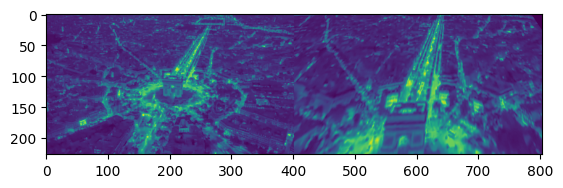

In [79]:
config_path = "./conf_file.cpg"
config = parse_config_file(config_path)

vid_capture = cv2.VideoCapture(config['videos'])
frames_to_process = 5

if config['transforms'][0][0] == 'homography':
    if config['transforms'][0][1] == 'all':
        homographies = homographies_from_features( features, frames_to_process)
    elif config['transforms'][0][1] == 'map':
        if len(config['pts_in_map']) != len(config['pts_in_frame']):
            print("Different amount of pts_in_map and pts_in_frame defined inside the config file")
            sys.exit(1)
        homographies = homographies_from_corresponding_points(config['pts_in_map'], config['pts_in_frame'])
    data={'transforms': np.array(homographies).transpose()}
    io.savemat(config['transforms_out'], data)
else:
    print("The only acceptable type is \"homography\"")